In [1]:
from bioinf_learn import MinHash
from bioinf_learn import WtaHash

%matplotlib inline
%load_ext memory_profiler
from bioinf_learn.util import measureCpuScalability
from bioinf_learn.util import measureCpuScalability_Gpu
from bioinf_learn.util import plotDataBenchmark
from bioinf_learn.util import plotData
from bioinf_learn.util import measureMinHashWtaHash
import time
import numpy as np

from eden.converter.graph.gspan import gspan_to_eden
from eden.graph import Vectorizer

from eden.converter.rna.rnafold import rnafold_to_eden
from eden.converter.fasta import fasta_to_sequence
from eden.graph import Vectorizer
from itertools import islice
import numpy as np
from scipy.sparse import vstack


import time
import numpy as np
def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)

def rfam_to_matrix(rfam_id, n_max=50, complexity=2, nbits=10):
    seqs = fasta_to_sequence(rfam_uri(rfam_id))
    seqs = islice(seqs,n_max)
    seqs = list(seqs)
    graphs = rnafold_to_eden(seqs)
    vectorizer = Vectorizer(complexity=complexity, nbits=nbits, positional=True)
    X = vectorizer.transform(graphs)
    return X

def rfam_data(rfam_ids, n_max=300, complexity=3, nbits=13):
    Xs = []
    targets = []
    for i,rfam_id in enumerate(rfam_ids):
        X=rfam_to_matrix(rfam_id, n_max=n_max, complexity=complexity, nbits=nbits)
        Xs.append(X)
        targets += [i] * X.shape[0]
    data_matrix = vstack(Xs, format="csr")
    targets = np.array(targets)    
    return data_matrix, targets

In [2]:
graphs = gspan_to_eden( 'http://www.bioinf.uni-freiburg.de/~costa/bursi.gspan' )
vectorizer = Vectorizer( r=2,d=5 )

%time %memit datasetBursi = vectorizer.transform( graphs )

peak memory: 396.23 MiB, increment: 282.14 MiB
CPU times: user 47.7 s, sys: 648 ms, total: 48.3 s
Wall time: 48.6 s


In [11]:
rfam_ids=['RF00004','RF00005','RF00015','RF00020','RF00026','RF00169',
          'RF00380','RF00386','RF01051','RF01055','RF01234','RF01699',
          'RF01701','RF01705','RF01731','RF01734','RF01745','RF01750',
          'RF01942','RF01998','RF02005','RF02012','RF02034']

%time %memit datasetRNA, y = rfam_data(rfam_ids, n_max=100, complexity=3, nbits=16)
print 'Instances: %d Features: %d with an avg of %d features per instance' % (datasetRNA.shape[0], datasetRNA.shape[1],  datasetRNA.getnnz()/datasetRNA.shape[0])
print "Sparsity: ", datasetRNA.nnz / float(datasetRNA.shape[0]) / datasetRNA.shape[1]

peak memory: 714.17 MiB, increment: 103.77 MiB
CPU times: user 2min 16s, sys: 37.3 s, total: 2min 54s
Wall time: 4min 17s
Instances: 2300 Features: 65537 with an avg of 3648 features per instance
Sparsity:  0.0556745907224


In [4]:
max_bin_size = 49
shingle_size = 2
minimal_blocks_in_common= 1
prune_inverse_index= 11
store_value_with_least_sigificant_bit=3
excess_factor= 11
prune_inverse_index_after_instance= 0.5
remove_hash_function_with_less_entries_as= 0
shingle= 0
block_size= 4
hash_functions = 596
minHash = [max_bin_size, shingle_size, minimal_blocks_in_common, prune_inverse_index, 
            store_value_with_least_sigificant_bit, excess_factor,
            prune_inverse_index_after_instance, remove_hash_function_with_less_entries_as,
            shingle, block_size, hash_functions]
cpu_cores = [1, 2, 4, 8, 16, 24, 32, 40, 48, 56, 64]

In [29]:
cpu_scalability_xeon = measureCpuScalability(datasetBursi, minHash, cpu_cores)

In [30]:
print cpu_scalability_xeon

[[7.558984041213989, 4.97288703918457, 3.050097942352295, 2.2129318714141846, 1.5361499786376953, 1.3508391380310059, 1.0612359046936035, 1.0176200866699219, 1.0814671516418457, 0.9778890609741211, 0.9636800289154053], [3.241766929626465, 3.3029959201812744, 2.57051682472229, 2.329803943634033, 2.315100908279419, 2.899880886077881, 3.1793580055236816, 3.562587022781372, 4.40560507774353, 4.879859924316406, 5.569935083389282], [4.775397062301636, 3.349313974380493, 2.212553024291992, 1.0945329666137695, 0.5783188343048096, 0.4788050651550293, 0.39224696159362793, 0.3295748233795166, 0.3232438564300537, 0.3098771572113037, 0.35496997833251953], [0.8969564214895088, 0.8969564214895088, 0.8970025363154254, 0.8969564214895088, 0.8969564214895088, 0.8970025363154254, 0.8969333640765507, 0.8969333640765507, 0.8969794789024671, 0.8969794789024671, 0.8969333640765507]]


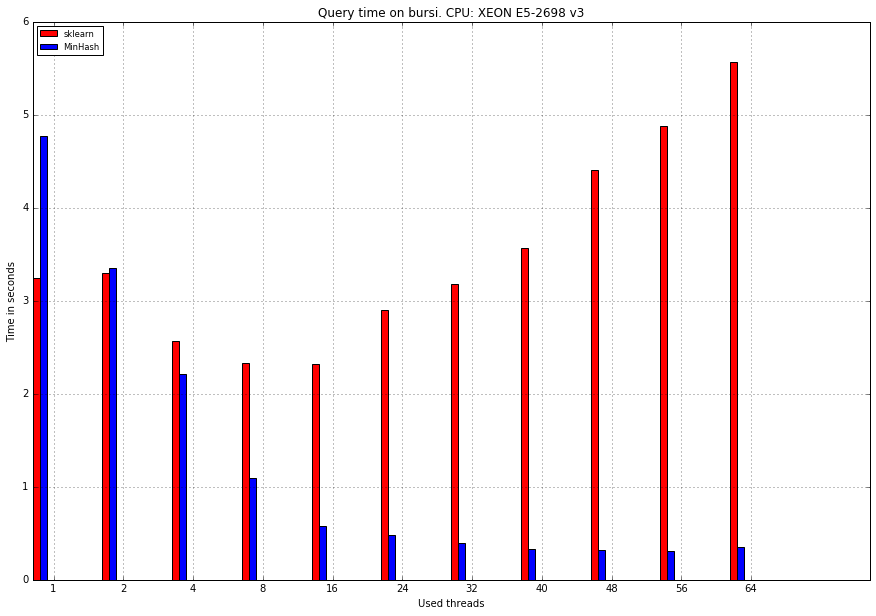

In [31]:
plotData(data=cpu_scalability_xeon[1:3], color=["r", "b"], label=["sklearn", "MinHash"],
        xticks=["1", "2", "4", "8", "16", "24", "32", "40", "48", "56", "64"], ylabel="Time in seconds", number_of_instances=11,
        xlabel="Used threads", log = False, figure_size=(15, 10), 
         number_of_features=1, title='Query time on bursi. CPU: XEON E5-2698 v3')

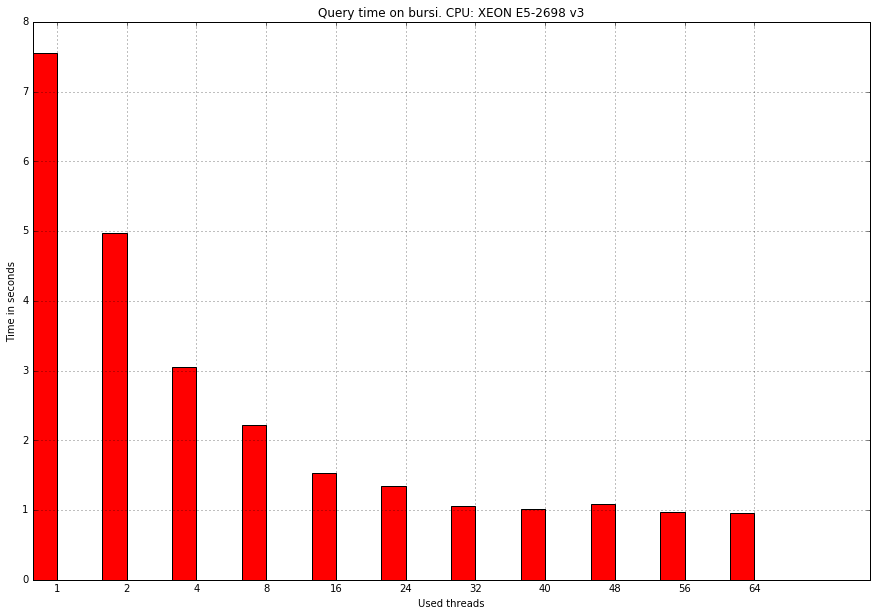

In [32]:
plotDataBenchmark(data=cpu_scalability_xeon[0], color=["r"], 
         label=[],
        xticks=["1", "2", "4", "8", "16", "24", "32", "40", "48", "56", "64"],
         ylabel="Time in seconds", number_of_instances=11, bar_width=0.35, figure_size=(15, 10),
        xlabel="Used threads", log = False,
         number_of_features=1, title='Query time on bursi. CPU: XEON E5-2698 v3')

In [3]:
cpu_cores = [1, 2, 4]
cpu_scalability_i5_6600 = measureCpuScalability(datasetBursi, minHash, cpu_cores)

NameError: name 'minHash' is not defined

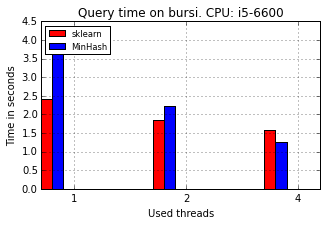

In [5]:
plotData(data=cpu_scalability_i5_6600[1:3], color=["r", "b"], label=["sklearn", "MinHash"],
        xticks=["1", "2", "4"], ylabel="Time in seconds", number_of_instances=3,
        xlabel="Used threads", log = False, figure_size=(5, 3),
         number_of_features=1, title='Query time on bursi. CPU: i5-6600')

/home/joachim/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


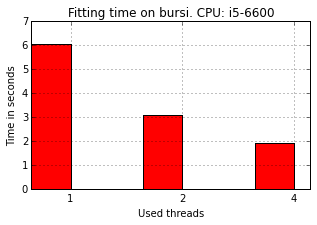

In [6]:
plotDataBenchmark(data=cpu_scalability_i5_6600[0], color=["r"], 
         label=[],
        xticks=["1", "2", "4"],
         ylabel="Time in seconds", number_of_instances=3, bar_width=0.35, figure_size=(5, 3),
        xlabel="Used threads", log = False,
         number_of_features=1, title='Fitting time on bursi. CPU: i5-6600')

In [5]:
cpu_cores = [1, 2, 4]
cpu_scalability_xeon_gpu = measureCpuScalability_Gpu(datasetBursi, minHash, cpu_cores)

In [6]:
print cpu_scalability_xeon_gpu

[[0.8974452018737793, 0.5994939804077148, 0.6163699626922607], [3.832519054412842, 3.678284168243408, 2.512199878692627], [1.2968809604644775, 1.0357508659362793, 0.9419941902160645], [0.8904311736223196, 0.8906848051648605, 0.8904542310352779]]


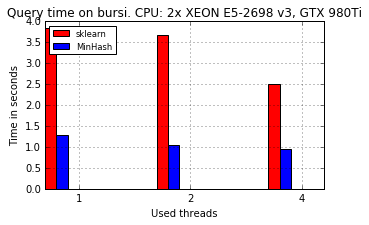

In [7]:
plotData(data=cpu_scalability_xeon_gpu[1:3], color=["r", "b"], label=["sklearn", "MinHash"],
        xticks=["1", "2", "4", "8", "16", "24", "32", "40", "48", "56", "64"], ylabel="Time in seconds",
         number_of_instances=3,
        xlabel="Used threads", log = False, figure_size=(5, 3), 
         number_of_features=1, title='Query time on bursi. CPU: 2x XEON E5-2698 v3, GTX 980Ti')

/home/fifty2_admin/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


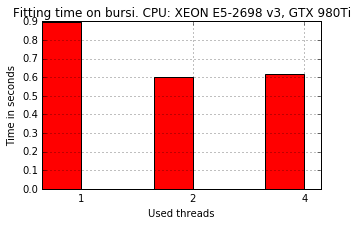

In [8]:
plotDataBenchmark(data=cpu_scalability_xeon_gpu[0], color=["r"], 
         label=[],
        xticks=["1", "2", "4", "8", "16", "24", "32", "40", "48", "56", "64"],
         ylabel="Time in seconds", number_of_instances=3, bar_width=0.35, figure_size=(5, 3),
        xlabel="Used threads", log = False,
         number_of_features=1, title='Fitting time on bursi. CPU: XEON E5-2698 v3, GTX 980Ti')

In [4]:
cpu_cores = [1, 2, 4]
cpu_scalability_i5_6600_750Ti = measureCpuScalability_Gpu(datasetBursi, minHash, cpu_cores)

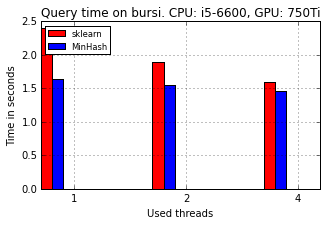

In [5]:
plotData(data=cpu_scalability_i5_6600_750Ti[1:3], color=["r", "b"], label=["sklearn", "MinHash"],
        xticks=["1", "2", "4"], ylabel="Time in seconds", number_of_instances=3,
        xlabel="Used threads", log = False, figure_size=(5, 3),
         number_of_features=1, title='Query time on bursi. CPU: i5-6600, GPU: 750Ti')

/home/joachim/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


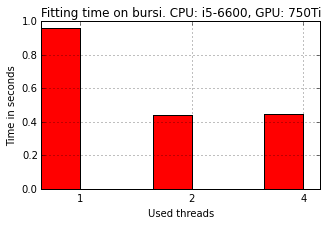

In [6]:
plotDataBenchmark(data=cpu_scalability_i5_6600_750Ti[0], color=["r"], 
         label=[],
        xticks=["1", "2", "4"],
         ylabel="Time in seconds", number_of_instances=3, bar_width=0.35, figure_size=(5, 3),
        xlabel="Used threads", log = False,
         number_of_features=1, title='Fitting time on bursi. CPU: i5-6600, GPU: 750Ti')

In [ ]:
cpu_cores = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
cpu_scalability_xeon = measureCpuScalability(datasetBursi, minHash, cpu_cores)

In [ ]:
cpu_cores = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
cpu_scalability_xeon_980Ti = measureCpuScalability_Gpu(datasetBursi, minHash, cpu_cores)

In [8]:
cpu_cores = [1, 2, 4]
cpu_scalability_i5_5200U = measureCpuScalability(datasetBursi, minHash, cpu_cores)

In [5]:
print cpu_scalability_i5_5200U

[[9.228111982345581, 4.981896162033081, 4.456392049789429], [4.089432954788208, 4.870645999908447, 3.817233085632324], [5.996991872787476, 3.311551094055176, 2.3043200969696045], [0.8975328568134655, 0.8975328568134655, 0.8975328568134655]]


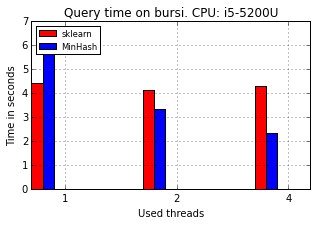

In [26]:

plotData(data=cpu_scalability_i5_5200U[1:3], color=["r", "b"], label=["sklearn", "MinHash"],
        xticks=["1", "2", "4"], ylabel="Time in seconds", number_of_instances=3,
        xlabel="Used threads", log = False, figure_size=(5, 3),
         number_of_features=1, title='Query time on bursi. CPU: i5-5200U')

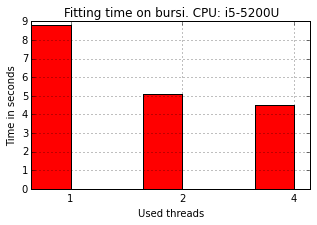

In [25]:
plotDataBenchmark(data=cpu_scalability_i5_5200U[0], color=["r"], 
         label=[],
        xticks=["1", "2", "4"],
         ylabel="Time in seconds", number_of_instances=3, bar_width=0.35, figure_size=(5, 3),
        xlabel="Used threads", log = False,
         number_of_features=1, title='Fitting time on bursi. CPU: i5-5200U')

In [4]:
cpu_cores = [1, 2, 4]
cpu_gpu_scalability_i5_5200U = measureCpuScalability_Gpu(datasetBursi, minHash, cpu_cores)

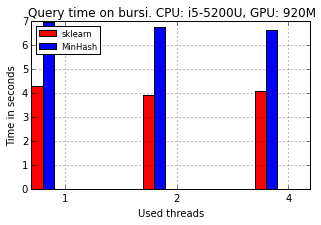

In [24]:
from bioinf_learn.util import plotData
plotData(data=cpu_gpu_scalability_i5_5200U[1:3], color=["r", "b"], label=["sklearn", "MinHash"],
        xticks=["1", "2", "4"], ylabel="Time in seconds", number_of_instances=3,
        xlabel="Used threads", log = False, figure_size=(5, 3),
         number_of_features=1, title='Query time on bursi. CPU: i5-5200U, GPU: 920M')

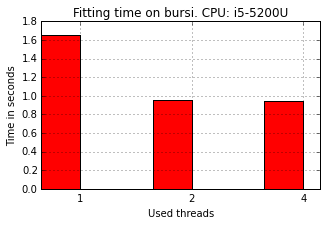

In [23]:
plotDataBenchmark(data=cpu_gpu_scalability_i5_5200U[0], color=["r"], 
         label=[],
        xticks=["1", "2", "4"],
         ylabel="Time in seconds", number_of_instances=3, bar_width=0.35, figure_size=(5, 3),
        xlabel="Used threads", log = False,
         number_of_features=1, title='Fitting time on bursi. CPU: i5-5200U')

### RNA dataset

In [12]:
max_bin_size = 89
shingle_size = 2
minimal_blocks_in_common= 1
prune_inverse_index= 8
store_value_with_least_sigificant_bit=3
excess_factor= 14
prune_inverse_index_after_instance= 0.5
remove_hash_function_with_less_entries_as= 0
shingle= 0
block_size= 4
hash_function = 660
minHash = [max_bin_size, shingle_size, minimal_blocks_in_common, prune_inverse_index, 
            store_value_with_least_sigificant_bit, excess_factor,
            prune_inverse_index_after_instance, remove_hash_function_with_less_entries_as,
            shingle, block_size, hash_functions]

In [9]:
cpu_cores = [1, 2, 4]
cpu_scalability_i5_6600_rna = measureCpuScalability(datasetRNA, minHash, cpu_cores)

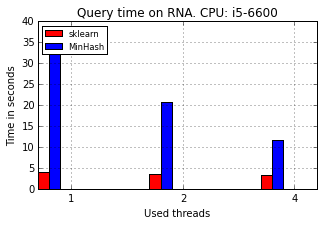

In [10]:
plotData(data=cpu_scalability_i5_6600_rna[1:3], color=["r", "b"], label=["sklearn", "MinHash"],
        xticks=["1", "2", "4"], ylabel="Time in seconds", number_of_instances=3,
        xlabel="Used threads", log = False, figure_size=(5, 3),
         number_of_features=1, title='Query time on RNA. CPU: i5-6600')

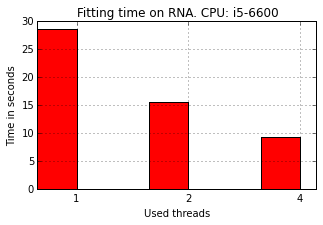

In [11]:
plotDataBenchmark(data=cpu_scalability_i5_6600_rna[0], color=["r"], 
         label=[],
        xticks=["1", "2", "4"],
         ylabel="Time in seconds", number_of_instances=3, bar_width=0.35, figure_size=(5, 3),
        xlabel="Used threads", log = False,
         number_of_features=1, title='Fitting time on RNA. CPU: i5-6600')

In [12]:
cpu_cores = [1, 2, 4]
cpu_gpu_scalability_i5_6600_750Ti_rna = measureCpuScalability_Gpu(datasetRNA, minHash, cpu_cores)

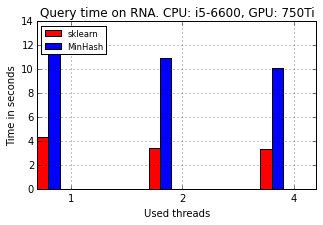

In [13]:
plotData(data=cpu_gpu_scalability_i5_6600_750Ti_rna[1:3], color=["r", "b"], label=["sklearn", "MinHash"],
        xticks=["1", "2", "4"], ylabel="Time in seconds", number_of_instances=3,
        xlabel="Used threads", log = False, figure_size=(5, 3),
         number_of_features=1, title='Query time on RNA. CPU: i5-6600, GPU: 750Ti')

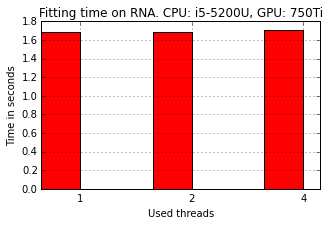

In [14]:
plotDataBenchmark(data=cpu_gpu_scalability_i5_6600_750Ti_rna[0], color=["r"], 
         label=[],
        xticks=["1", "2", "4"],
         ylabel="Time in seconds", number_of_instances=3, bar_width=0.35, figure_size=(5, 3),
        xlabel="Used threads", log = False,
         number_of_features=1, title='Fitting time on RNA. CPU: i5-5200U, GPU: 750Ti')

In [37]:
cpu_cores = [1, 2, 4]
cpu_scalability_i5_5200U_rna = measureCpuScalability(datasetRNA, minHash, cpu_cores)

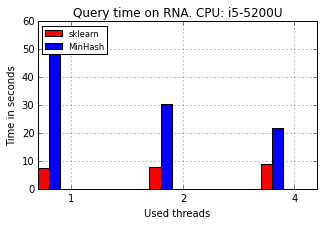

In [38]:
plotData(data=cpu_scalability_i5_5200U_rna[1:3], color=["r", "b"], label=["sklearn", "MinHash"],
        xticks=["1", "2", "4"], ylabel="Time in seconds", number_of_instances=3,
        xlabel="Used threads", log = False, figure_size=(5, 3),
         number_of_features=1, title='Query time on RNA. CPU: i5-5200U')

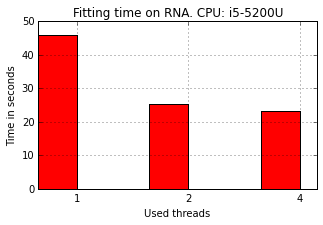

In [39]:
plotDataBenchmark(data=cpu_scalability_i5_5200U_rna[0], color=["r"], 
         label=[],
        xticks=["1", "2", "4"],
         ylabel="Time in seconds", number_of_instances=3, bar_width=0.35, figure_size=(5, 3),
        xlabel="Used threads", log = False,
         number_of_features=1, title='Fitting time on RNA. CPU: i5-5200U')

In [40]:
cpu_cores = [1, 2, 4]
cpu_gpu_scalability_i5_5200U_rna = measureCpuScalability_Gpu(datasetRNA, minHash, cpu_cores)

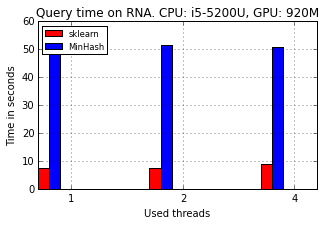

In [41]:
plotData(data=cpu_gpu_scalability_i5_5200U_rna[1:3], color=["r", "b"], label=["sklearn", "MinHash"],
        xticks=["1", "2", "4"], ylabel="Time in seconds", number_of_instances=3,
        xlabel="Used threads", log = False, figure_size=(5, 3),
         number_of_features=1, title='Query time on RNA. CPU: i5-5200U, GPU: 920M')

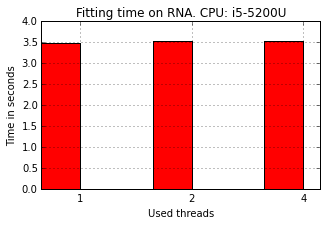

In [42]:
plotDataBenchmark(data=cpu_gpu_scalability_i5_5200U_rna[0], color=["r"], 
         label=[],
        xticks=["1", "2", "4"],
         ylabel="Time in seconds", number_of_instances=3, bar_width=0.35, figure_size=(5, 3),
        xlabel="Used threads", log = False,
         number_of_features=1, title='Fitting time on RNA. CPU: i5-5200U')

In [13]:
cpu_cores = [1, 2, 4, 8, 16, 24, 32, 40, 48, 56, 64]
cpu_scalability_XEON_rna = measureCpuScalability(datasetRNA, minHash, cpu_cores)

In [14]:
print cpu_scalability_XEON_rna

[[62.025007009506226, 26.456130027770996, 13.991635084152222, 9.657891035079956, 5.9742279052734375, 4.890188932418823, 4.597015857696533, 3.940402030944824, 3.742563009262085, 3.485024929046631, 3.7133660316467285], [9.34251093864441, 6.682345867156982, 4.080047130584717, 4.790035009384155, 4.788784980773926, 6.211323022842407, 8.201133966445923, 9.832102060317993, 12.96407699584961, 16.077122926712036, 16.766930103302002], [43.74154806137085, 26.448181867599487, 15.900454998016357, 8.68753695487976, 5.325472116470337, 4.092710971832275, 3.364384889602661, 2.7942440509796143, 2.6099188327789307, 2.2489449977874756, 2.3203928470611572], [0.6071739130434782, 0.6071739130434782, 0.6071739130434782, 0.6071739130434782, 0.6071739130434782, 0.6071739130434782, 0.6071739130434782, 0.6071739130434782, 0.6071739130434782, 0.6071739130434782, 0.6071739130434782]]


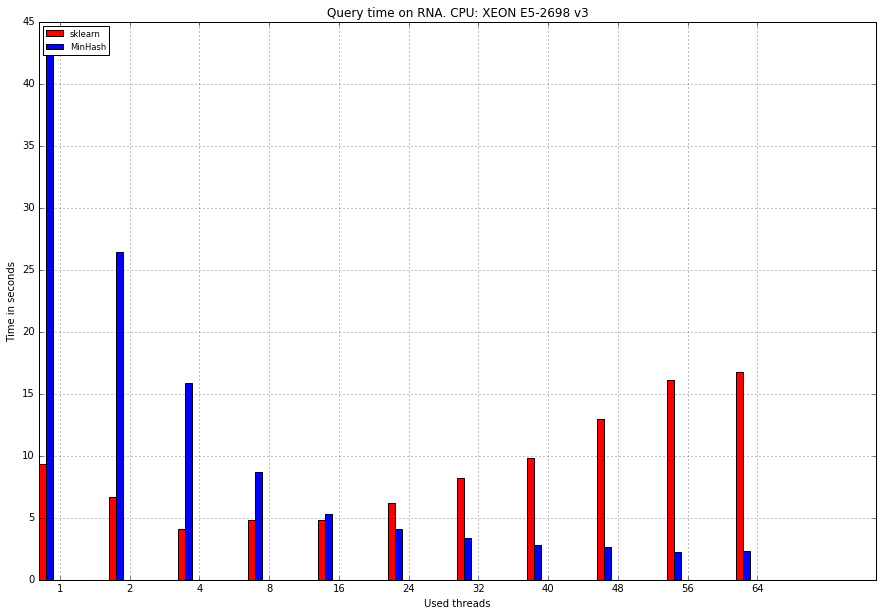

In [17]:
plotData(data=cpu_scalability_XEON_rna[1:3], color=["r", "b"], label=["sklearn", "MinHash"],
        xticks=["1", "2", "4", "8", "16", "24","32", "40", "48","56", "64"], ylabel="Time in seconds", number_of_instances=11,
        xlabel="Used threads", log = False, figure_size=(15, 10),
         number_of_features=1, title='Query time on RNA. CPU: XEON E5-2698 v3')

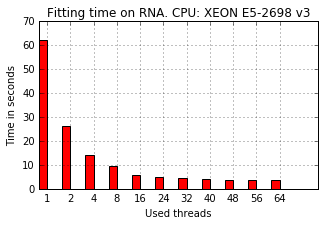

In [20]:
plotDataBenchmark(data=cpu_scalability_XEON_rna[0], color=["r"], 
         label=[],
        xticks=["1", "2", "4", "8", "16", "24","32", "40", "48","56", "64"],
         ylabel="Time in seconds", number_of_instances=11, bar_width=0.35, figure_size=(5, 3),
        xlabel="Used threads", log = False,
         number_of_features=1, title='Fitting time on RNA. CPU: XEON E5-2698 v3')

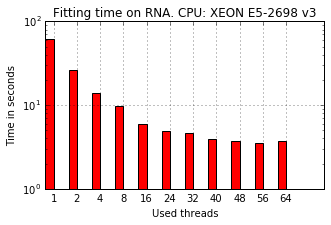

In [26]:
plotDataBenchmark(data=cpu_scalability_XEON_rna[0], color=["r"], 
         label=[],
        xticks=["1", "2", "4", "8", "16", "24","32", "40", "48","56", "64"],
         ylabel="Time in seconds", number_of_instances=11, bar_width=0.35, figure_size=(5, 3),
        xlabel="Used threads", log = True,
         number_of_features=1, title='Fitting time on RNA. CPU: XEON E5-2698 v3')

In [21]:
cpu_cores = [1, 2, 4]
cpu_gpu_scalability_XEON_gpu_rna = measureCpuScalability_Gpu(datasetRNA, minHash, cpu_cores)

In [23]:
print cpu_gpu_scalability_XEON_gpu_rna

[[1.845970869064331, 2.031071186065674, 2.000746965408325], [5.3820481300354, 5.636196136474609, 3.3484678268432617], [7.130803108215332, 6.099231004714966, 4.627452850341797], [0.569391304347826, 0.5680434782608695, 0.5705217391304348]]


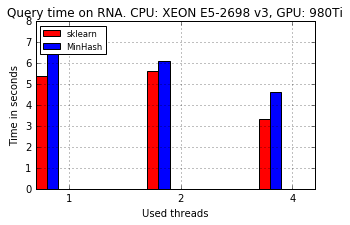

In [24]:
plotData(data=cpu_gpu_scalability_XEON_gpu_rna[1:3], color=["r", "b"], label=["sklearn", "MinHash"],
        xticks=["1", "2", "4"], ylabel="Time in seconds", number_of_instances=3,
        xlabel="Used threads", log = False, figure_size=(5, 3),
         number_of_features=1, title='Query time on RNA. CPU: XEON E5-2698 v3, GPU: 980Ti')

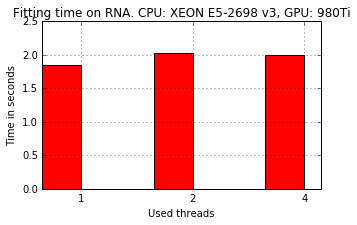

In [25]:
plotDataBenchmark(data=cpu_gpu_scalability_XEON_gpu_rna[0], color=["r"], 
         label=[],
        xticks=["1", "2", "4"],
         ylabel="Time in seconds", number_of_instances=3, bar_width=0.35, figure_size=(5, 3),
        xlabel="Used threads", log = False,
         number_of_features=1, title='Fitting time on RNA. CPU: XEON E5-2698 v3, GPU: 980Ti')